In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
def create_centered_mean(series):
    series = pd.DataFrame(series)
    centered_avg = series.rolling(window = 5)
    centered_avg = centered_avg.mean()
    return centered_avg

In [3]:
def data_loading():
    rider_df = pd.read_csv('downsampled_rider.csv.gz', 
                  parse_dates = ['starttime', 'stoptime', 'start_date', 'stop_date'])
    station_data = pd.read_csv('stations_cleaned.csv.gz', usecols = ['dock_id','dock_name','date','hour',
                                                                      'minute','avail_bikes','time'])

    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    rider_df = rider_df.set_index('starttime')
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index('datetime')
    station_data = station_data.drop(['date','hour','minute','time'], axis =1)
    non_zero = station_data[station_data['avail_bikes'] != 0].copy()
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'), 'start station id'])['stoptime'].count()
    non_zero = non_zero.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    station_data = station_data.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    rider_df_0 = pd.DataFrame(rider_df).merge(non_zero, left_index = True, right_on = ['datetime','dock_id']).copy()
    rider_df_0 = rider_df_0.reset_index().set_index('datetime')
    rider_df_0 = rider_df_0.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df_0 = rider_df_0.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()
    rider_df = pd.DataFrame(rider_df).merge(station_data, left_index = True, right_on = ['datetime','dock_id'])
    rider_df = rider_df.reset_index().set_index('datetime')
    rider_df = rider_df.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()

    return rider_df, rider_df_0

In [4]:
rider_df, rider_df_0 = data_loading()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
rider_demand_0 = pd.Series(rider_df_0[pd.IndexSlice[:,0]])

In [6]:
true_rides_0 = pd.Series(rider_df[pd.IndexSlice[:,0]])

In [7]:
X = rider_demand_0.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    demand = ARIMA(history, order=(5,1,0))
    demand_fit = demand.fit()
    output = demand_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 181.765


In [8]:
residuals = demand_fit.resid
residuals = pd.DataFrame(residuals)
print(demand_fit.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:35:45   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<ipython-input-9-3a40609fd462>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_0.index.strftime('%Y-%m'),rotation=90)


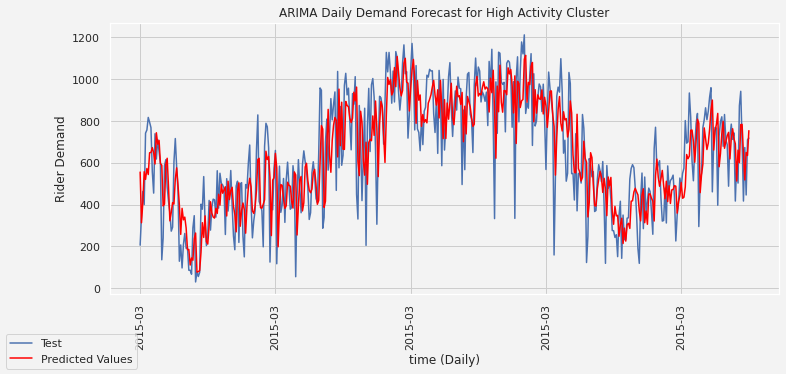

In [9]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_0.index.strftime('%Y-%m'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Rider Demand')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Demand Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

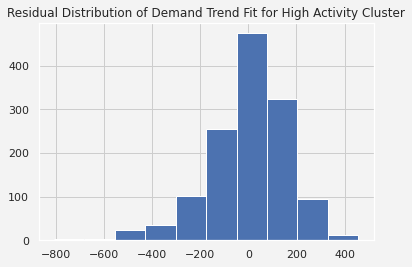

In [10]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Demand Trend Fit for High Activity Cluster')
plt.show

In [11]:
X = true_rides_0.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    real_demand = ARIMA(history, order=(5,1,0))
    real_demand_fit = real_demand.fit()
    output = real_demand_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 181.923


<ipython-input-12-01b5c77ae978>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_0.index.strftime('%Y-%m'),rotation=90)


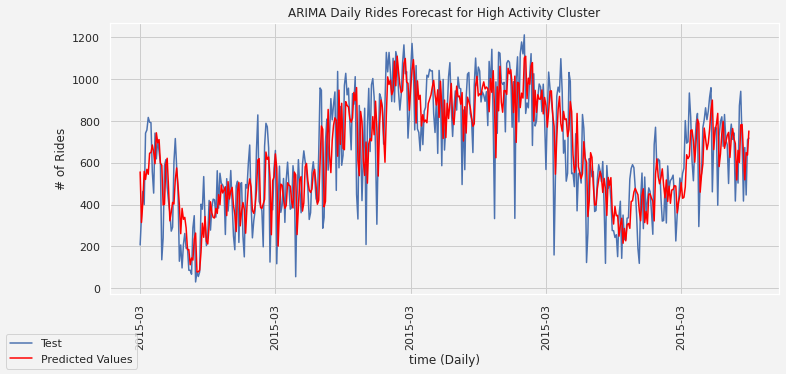

In [12]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_0.index.strftime('%Y-%m'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('# of Rides')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Rides Forecast for High Activity Cluster')
plt.show()

In [13]:
residuals = real_demand_fit.resid
residuals = pd.DataFrame(residuals)
print(real_demand_fit.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:36:30   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

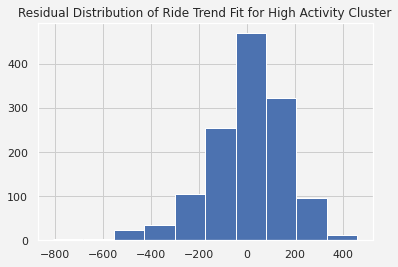

In [14]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for High Activity Cluster')
plt.show

In [15]:
rider_demand_1 = pd.Series(rider_df_0[pd.IndexSlice[:,1]])

In [16]:
true_rides_1 = pd.Series(rider_df[pd.IndexSlice[:,1]])

In [17]:
X = rider_demand_1.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    demand_cluster_1 = ARIMA(history, order=(5,1,0))
    demand_cluster_1_fit = demand_cluster_1.fit()
    output = demand_cluster_1_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 80.643


<ipython-input-18-8c3d6275716a>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_1.index.strftime('%Y'),rotation=90)


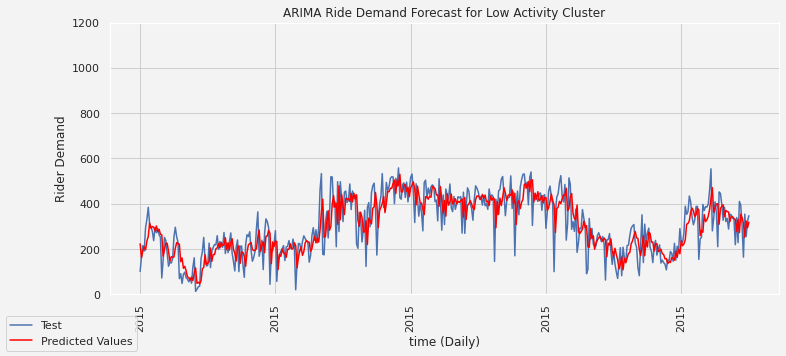

In [18]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_1.index.strftime('%Y'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('Rider Demand')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Ride Demand Forecast for Low Activity Cluster')
plt.show()

In [19]:
residuals = demand_cluster_1_fit.resid
residuals = pd.DataFrame(residuals)
print(demand_cluster_1_fit.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:37:14   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

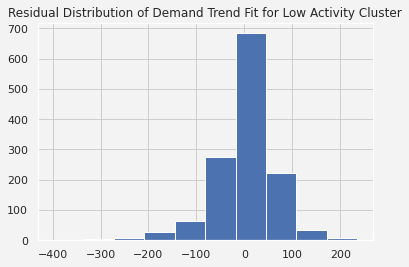

In [20]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Demand Trend Fit for Low Activity Cluster')
plt.show

In [21]:
X = true_rides_1.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    true_cluster_1 = ARIMA(history, order=(5,1,0))
    true_cluster_1_fit = true_cluster_1.fit()
    output = true_cluster_1_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 80.663


<ipython-input-22-273c29e9bb41>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_1.index.strftime('%Y'),rotation=90)


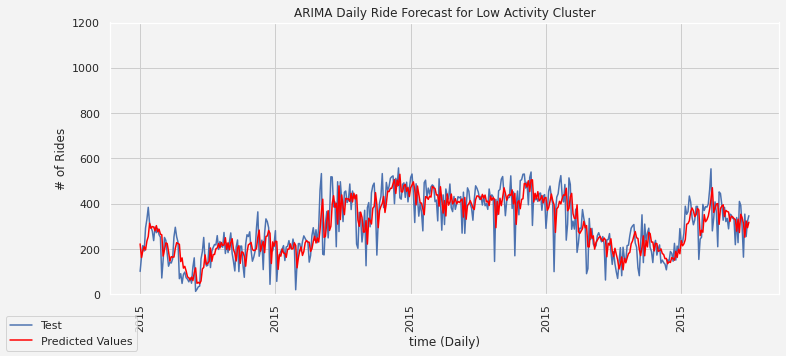

In [22]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_1.index.strftime('%Y'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Forecast for Low Activity Cluster')
plt.show()

In [23]:
residuals = true_cluster_1_fit.resid
residuals = pd.DataFrame(residuals)
print(true_cluster_1_fit.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:38:00   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

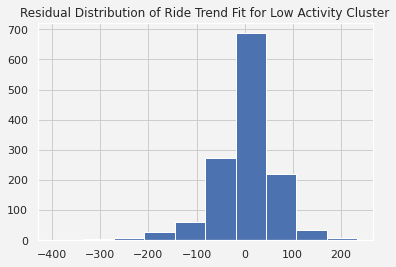

In [24]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for Low Activity Cluster')
plt.show

In [25]:
rider_demand_2 = pd.Series(rider_df_0[pd.IndexSlice[:,2]])

In [26]:
true_rides_2 = pd.Series(rider_df[pd.IndexSlice[:,2]])

In [27]:
X = rider_demand_2.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    demand_cluster_2 = ARIMA(history, order=(5,1,0))
    demand_cluster_2_fit = demand_cluster_2.fit()
    output = demand_cluster_2_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 157.711


<ipython-input-28-32dfbacde615>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_2.index.strftime('%Y'),rotation=90)


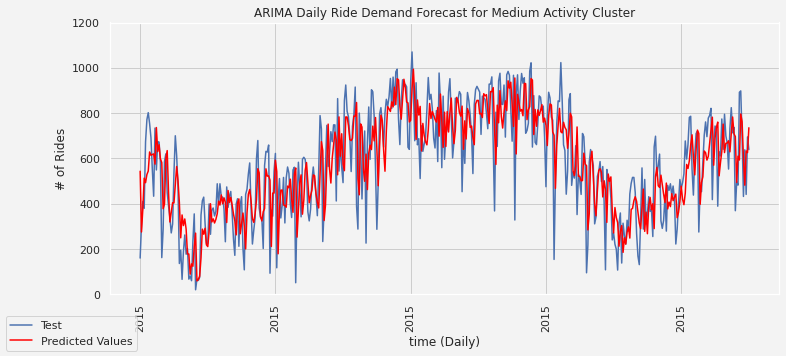

In [28]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_2.index.strftime('%Y'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Demand Forecast for Medium Activity Cluster')
plt.show()

In [29]:
residuals = demand_cluster_2_fit.resid
residuals = pd.DataFrame(residuals)
print(demand_cluster_2_fit.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:38:48   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

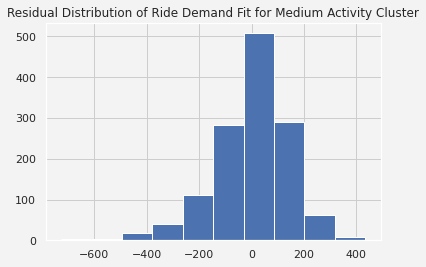

In [30]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Demand Fit for Medium Activity Cluster')
plt.show

In [31]:
X = true_rides_2.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
residuals = []
predictions = list()
# walk-forward validation
for t in range(len(test)):
    true_cluster_2 = ARIMA(history, order=(5,1,0))
    true_cluster_2_fit = true_cluster_2.fit()
    output = true_cluster_2_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) 
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


Test RMSE: 157.792


<ipython-input-32-edf87b901e02>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_2.index.strftime('%Y'),rotation=90)


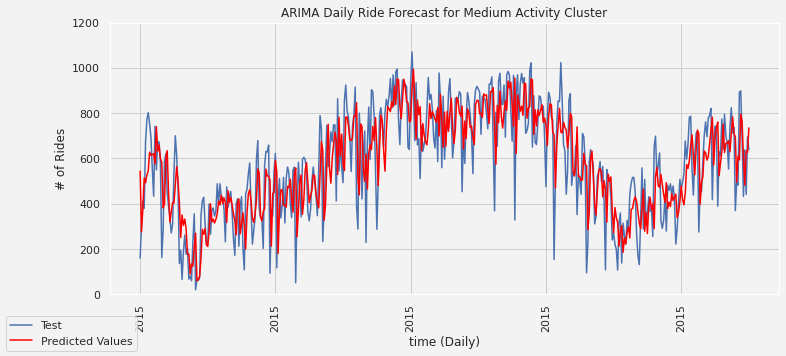

In [32]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_2.index.strftime('%Y'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Forecast for Medium Activity Cluster')
plt.show()

In [33]:
residuals = true_cluster_2_fit.resid
residuals = pd.DataFrame(residuals)
print(true_cluster_2.summary())
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8625.620
Date:                Sun, 20 Dec 2020   AIC                          17263.239
Time:                        07:39:36   BIC                          17294.365
Sample:                             0   HQIC                         17274.908
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5049      0.024    -21.113      0.000      -0.552      -0.458
ar.L2         -0.4549      0.026    -17.427      0.000      -0.506      -0.404
ar.L3         -0.3915      0.028    -13.779      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

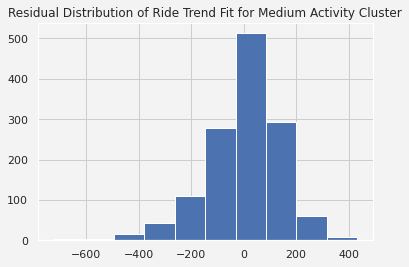

In [34]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for Medium Activity Cluster')
plt.show

<ipython-input-43-f45f881658a9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_2.index.strftime('%Y'),rotation=90)


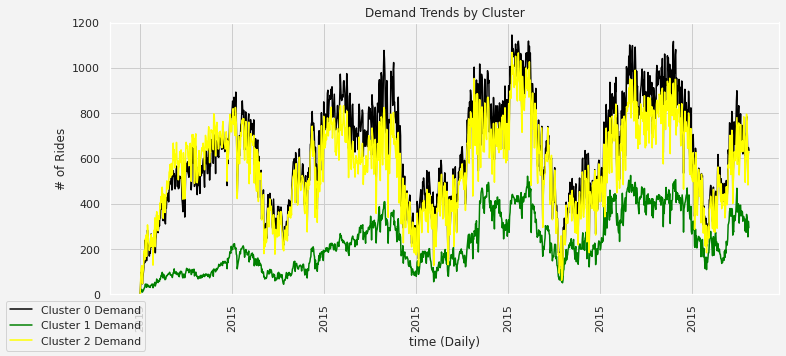

In [43]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_2.index.strftime('%Y'),rotation=90)
ax1.set_xlabel('time (Daily)')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(demand_fit.fittedvalues, color = 'black')
plt.plot(demand_cluster_1_fit.fittedvalues, color='green')
plt.plot(demand_cluster_2_fit.fittedvalues, color='yellow')
fig.legend(['Cluster 0 Demand','Cluster 1 Demand', 'Cluster 2 Demand'], loc=3)
plt.title('Demand Trends by Cluster')
plt.show()